In [124]:
import pandas as pd
import numpy as np
import os
import kagglehub
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf  # добавили pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error



# Фиксируем "случайность" для воспроизводимости
np.random.seed(42)

## Подготовка данных

In [125]:
path = kagglehub.dataset_download("berkeleyearth/climate-change-earth-surface-temperature-data")

# Проверим, что внутри
for file in os.listdir(path):
  print(file)

GlobalLandTemperaturesByState.csv
GlobalTemperatures.csv
GlobalLandTemperaturesByCountry.csv
GlobalLandTemperaturesByMajorCity.csv
GlobalLandTemperaturesByCity.csv


*   **dt** - Дата
*   **AverageTemperature** -  средняя глобальная температура суши в градусах Цельсия.
*   **AverageTemperatureUncertainty** - 95% доверительный интервал вокруг среднего значения.
*   **Country** - Страна, в которой расположен город.

In [126]:
df = pd.read_csv(path+"/GlobalLandTemperaturesByCountry.csv")

In [127]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [128]:
df_cn = df[df.Country == 'China'].copy()
df_cn['dt'] = pd.to_datetime(df_cn['dt'])
print("Размер датафрейма:", df_cn.shape)
print("Информация о датафрейме:")
print(df_cn.info())
print("Пропущенные значения: \n", df_cn.isnull().sum())
df_cn.head()


Размер датафрейма: (2318, 4)
Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
Index: 2318 entries, 110149 to 112466
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   dt                             2318 non-null   datetime64[ns]
 1   AverageTemperature             2201 non-null   float64       
 2   AverageTemperatureUncertainty  2201 non-null   float64       
 3   Country                        2318 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 90.5+ KB
None
Пропущенные значения: 
 dt                                 0
AverageTemperature               117
AverageTemperatureUncertainty    117
Country                            0
dtype: int64


,dt,AverageTemperature,AverageTemperatureUncertainty,Country
110149,1820-08-01,16.684,1.978,China
110150,1820-09-01,13.292,1.555,China
110151,1820-10-01,5.624,1.383,China
110152,1820-11-01,-1.981,1.340,China
110153,1820-12-01,-8.551,1.508,China


In [129]:
df_cn = df_cn.dropna()
df_cn.isnull().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
Country                          0
dtype: int64

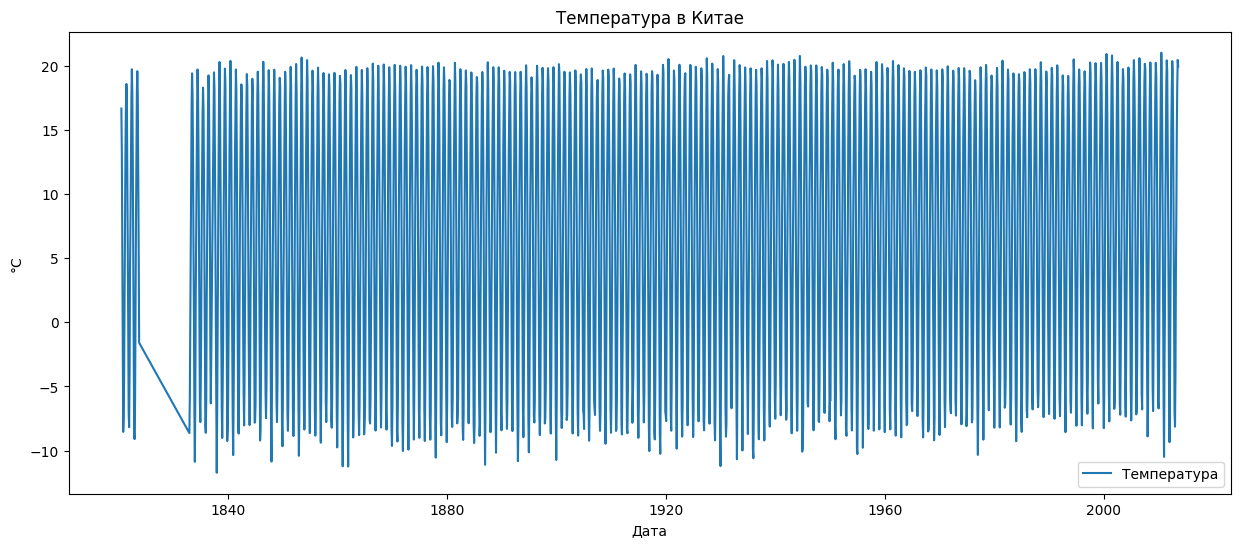

In [130]:
plt.figure(figsize=(15,6))
plt.plot(df_cn.dt, df_cn["AverageTemperature"], label="Температура")
plt.title("Температура в Китае")
plt.xlabel("Дата")
plt.ylabel("°C")
plt.legend()
plt.show()

Так как есть пириуед где не было замеров скорее всего из за того что в 1824–1832 годах Китай находился в состоянии упадка, характеризующегося усилением коррупции, экономическими трудностями и ростом социальной напряженности по этому данные взяты с 1833

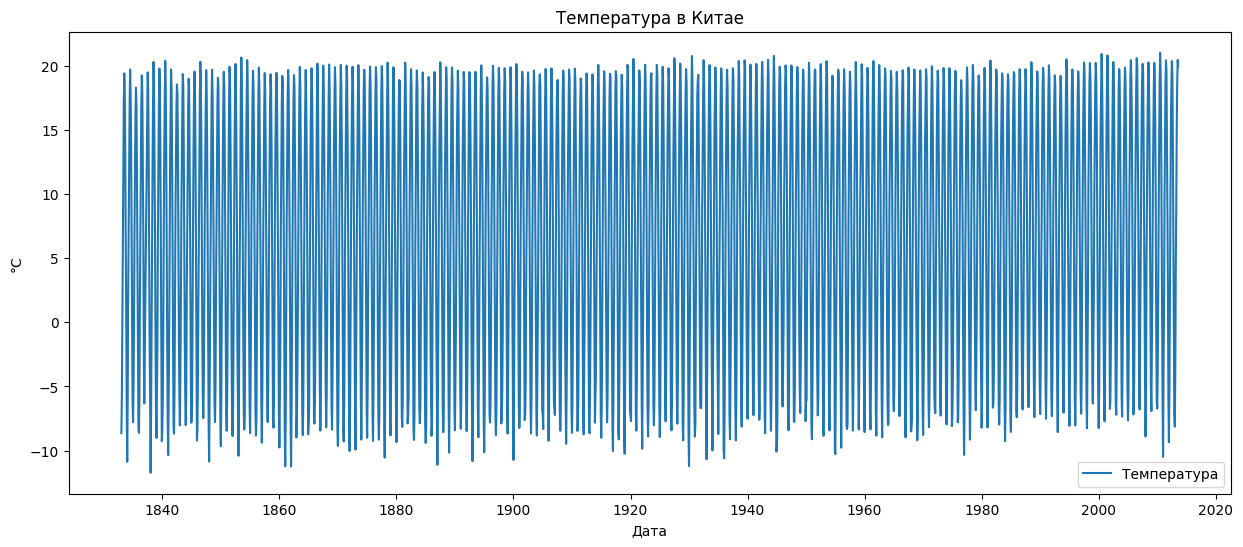

In [131]:
df_short = df_cn[df_cn.dt >= '1833-01-01']

plt.figure(figsize=(15,6))
plt.plot(df_short.dt, df_short["AverageTemperature"], label="Температура")
plt.title("Температура в Китае")
plt.xlabel("Дата")
plt.ylabel("°C")
plt.legend()
plt.show()

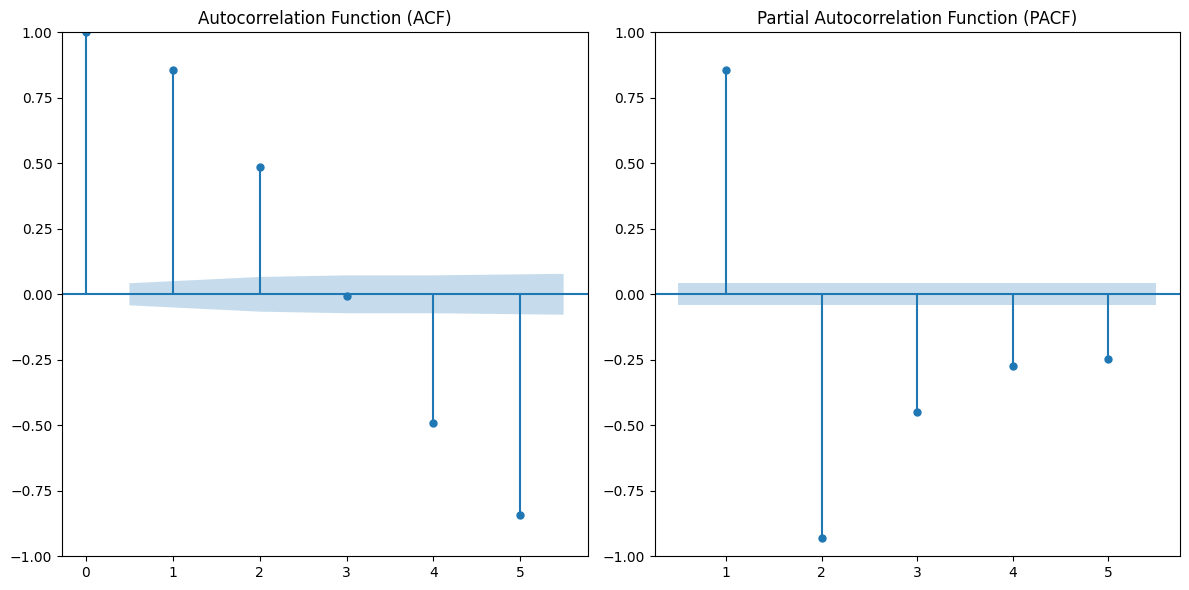

ACF значения (лаги 0-5):
[ 1.          0.85698838  0.48729792 -0.00726011 -0.4930706  -0.842427  ]

PACF значения (лаги 0-5):
[ 1.          0.85738513 -0.93381875 -0.45218429 -0.27873451 -0.25619951]


In [132]:
# === ACF (Автокорреляция) ===
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(df_short['AverageTemperature'], lags=5, ax=plt.gca(), title='Autocorrelation Function (ACF)')
# ax=plt.gca() — используется, чтобы plot_acf рисовал в текущей оси
# === PACF (Частичная автокорреляция) ===
plt.subplot(1, 2, 2)
plot_pacf(df_short['AverageTemperature'], lags=5, ax=plt.gca(), title='Partial Autocorrelation Function (PACF)', zero=False)
# zero=False — не показывать лаг 0 (опционально, но часто так делают)
plt.tight_layout()
plt.show()
# === Вычисление значений ACF и PACF ===
acf_values = acf(df_short['AverageTemperature'], nlags=5)
pacf_values = pacf(df_short['AverageTemperature'], nlags=5)
print("ACF значения (лаги 0-5):")
print(acf_values)
print("\nPACF значения (лаги 0-5):")
print(pacf_values)


Анализ автокорреляционных функций выявил четкие признаки авторегрессионного процесса второго порядка AR(2). Функция частной автокорреляции (PACF) демонстрирует резкий обрыв после второго лага, что указывает на прямую зависимость текущего значения ряда от двух предыдущих наблюдений. При этом функция автокорреляции (ACF) показывает плавное затухание. Так же случные колебания крайне низки. Это говорит о том что в данных крайне мало шумов

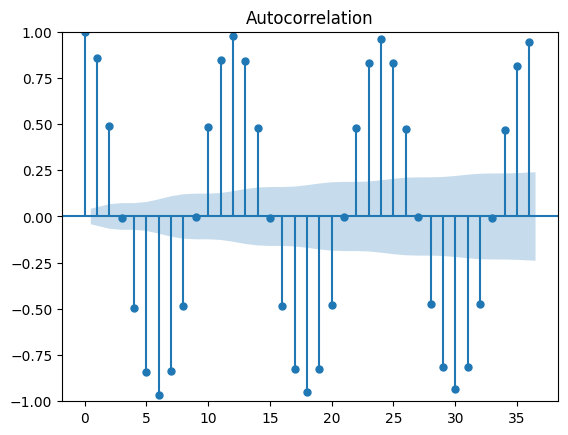

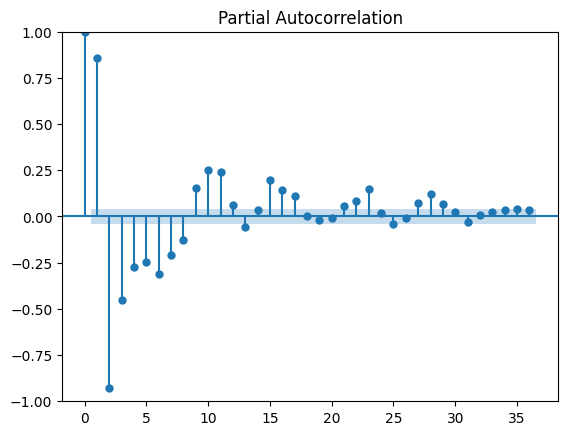

In [133]:
plot_acf(df_short["AverageTemperature"], lags=36)
plt.show()

plot_pacf(df_short["AverageTemperature"], lags=36)
plt.show()


## Holdout-разбиение.

In [134]:
# Определяем точку разбиения (80% для обучения)
split_index = int(len(df_short) * 0.8)

# Разделяем данные
train_data = df_short[:split_index]  # Первые 80%
test_data = df_short[split_index:]   # Последние 20%

print(f"Общий размер ряда: {len(df_short)}")
print(f"Обучающая выборка: {len(train_data)} наблюдений")
print(f"Тестовая выборка: {len(test_data)} наблюдений")

Общий размер ряда: 2161
Обучающая выборка: 1728 наблюдений
Тестовая выборка: 433 наблюдений


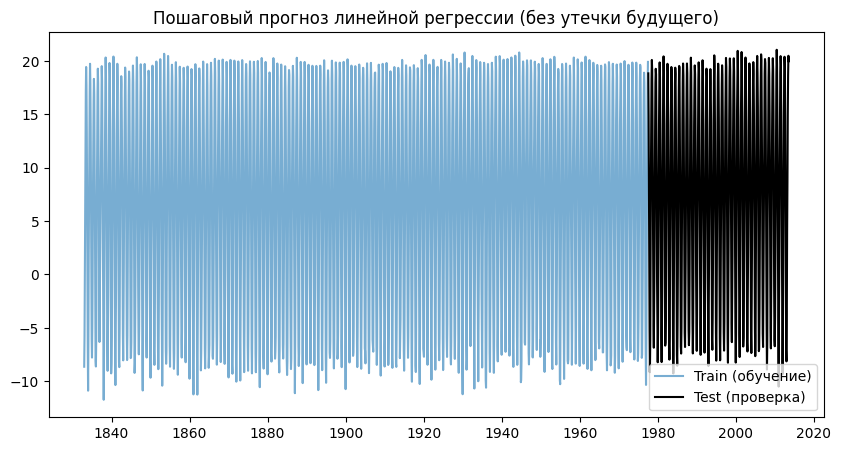

In [135]:
# --- Визуализация ---
plt.figure(figsize=(10,5))
plt.plot(train_data.dt, train_data["AverageTemperature"], label="Train (обучение)", alpha=0.6)
plt.plot(test_data.dt, test_data["AverageTemperature"], label="Test (проверка)", color="black")
plt.title("Пошаговый прогноз линейной регрессии (без утечки будущего)")
plt.legend()
plt.show()

## Скользящее окно.

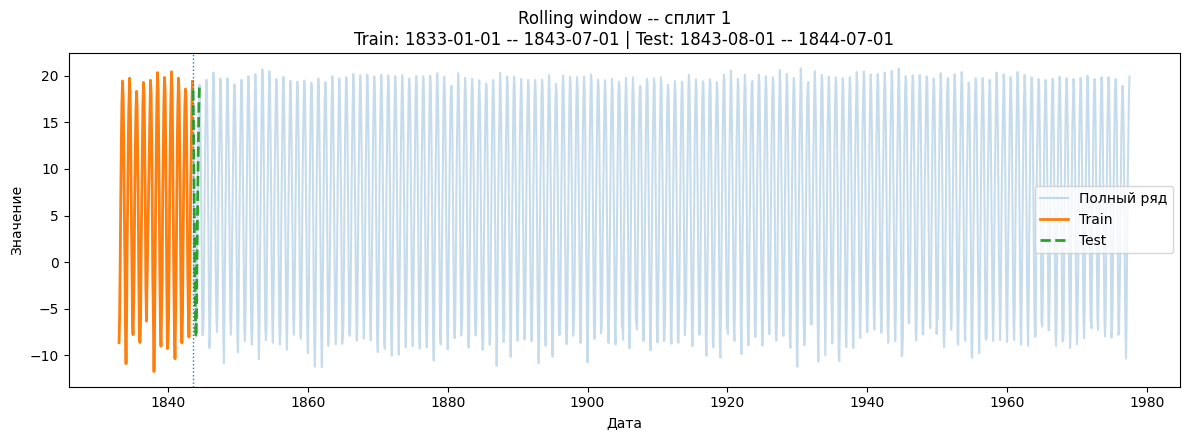

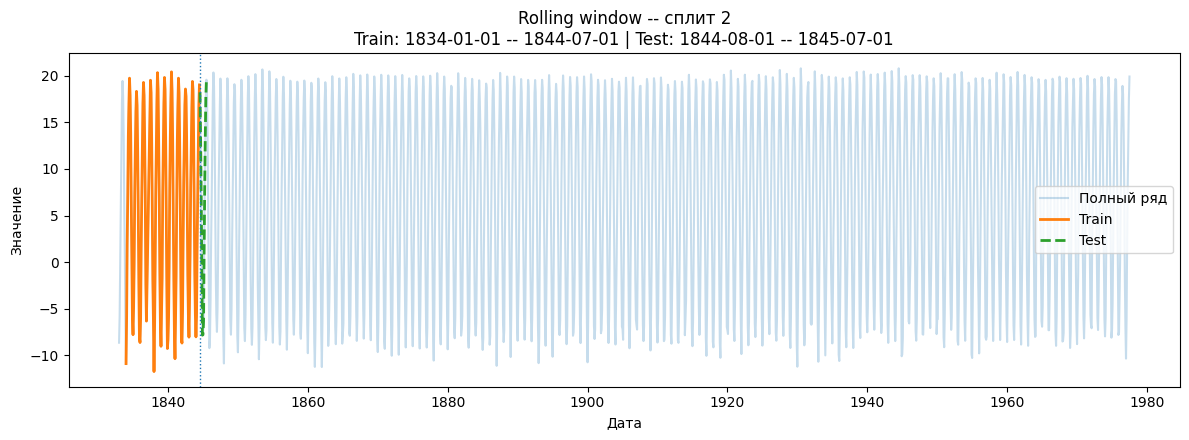

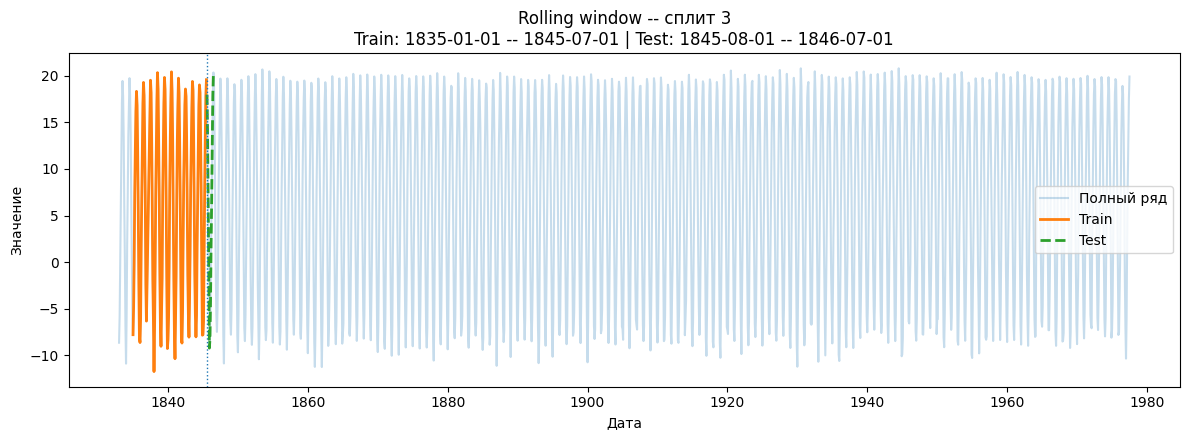

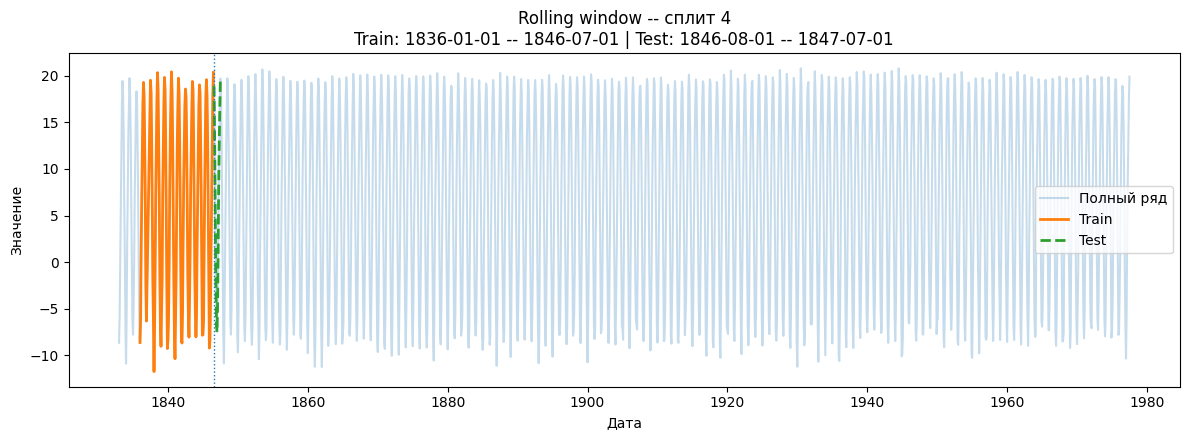

In [136]:
import matplotlib.pyplot as plt
 
window_size = 120  # Дней для обучения
horizon = 12  	# Дней для прогноза
 
# Соберем окна
splits = []
for start in range(0, len(train_data) - window_size - horizon + 1, horizon):
	train_window = train_data.iloc[start:start+window_size]
	test_window = train_data.iloc[start+window_size:start+window_size+horizon]
	splits.append((train_window, test_window))
 
# Рисуем первые четыре сплита
for i, (train_window, test_window) in enumerate(splits[:4], start=1):
	plt.figure(figsize=(12, 4.5))
	
	# Весь ряд — фоном
	plt.plot(train_data.dt, train_data['AverageTemperature'], alpha=0.25, label='Полный ряд')
	# Train
	plt.plot(train_window.dt, train_window['AverageTemperature'], linewidth=2, label='Train')
	# Test
	plt.plot(test_window.dt, test_window['AverageTemperature'], linewidth=2, linestyle='--', label='Test')
	# Вертикальная линия-раздел
	plt.axvline(test_window.dt.iloc[0], linestyle=':', linewidth=1)
 
	plt.title(f'Rolling window -- сплит {i}\n'
          	f'Train: {train_window.dt.iloc[0].date()} -- {train_window.dt.iloc[-1].date()} | '
          	f'Test: {test_window.dt.iloc[0].date()} -- {test_window.dt.iloc[-1].date()}')
	plt.xlabel('Дата')
	plt.ylabel('Значение')
	plt.legend()
	plt.tight_layout()
	plt.show()

 ## Генерация признаков

In [137]:
df_short = df_short.copy()

# Создаем лаги и календарные признаки
df_short['lag_1'] = df_short['AverageTemperature'].shift(1)
df_short['lag_12'] = df_short['AverageTemperature'].shift(12)
df_short['month'] = df_short['dt'].dt.month
df_short['winter_season'] = df_short['month'].isin([12, 1, 2]).astype(int)

# Информация о данных
print(f"\nИнформация о данных:")
print(f"Всего строк: {len(df_short)}")
print(f"Период: с {df_short['dt'].min()} по {df_short['dt'].max()}")
print(f"Количество стран: {df_short['Country'].nunique()}")

df_short = df_short.dropna()
df_short.head()


Информация о данных:
Всего строк: 2161
Период: с 1833-01-01 00:00:00 по 2013-08-01 00:00:00
Количество стран: 1


,dt,AverageTemperature,AverageTemperatureUncertainty,Country,lag_1,lag_12,month,winter_season
110310,1834-01-01,-10.881,1.367,China,-6.853,-8.637,1,1
110311,1834-02-01,-5.797,1.777,China,-10.881,-5.766,2,1
110312,1834-03-01,1.896,1.537,China,-5.797,-0.212,3,0
110313,1834-04-01,7.279,2.097,China,1.896,6.847,4,0
110314,1834-05-01,13.542,1.431,China,7.279,12.857,5,0


## Оценка прогноза

In [138]:
# Определяем точку разбиения (80% для обучения)
split_index = int(len(df_short) * 0.8)

# Разделяем данные
train_data = df_short[:split_index]  # Первые 80%
test_data = df_short[split_index:]   # Последние 20%

print(f"Общий размер ряда: {len(df_short)}")
print(f"Обучающая выборка: {len(train_data)} наблюдений")
print(f"Тестовая выборка: {len(test_data)} наблюдений")

Общий размер ряда: 2149
Обучающая выборка: 1719 наблюдений
Тестовая выборка: 430 наблюдений


In [139]:
train_data.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,lag_1,lag_12,month,winter_season
110310,1834-01-01,-10.881,1.367,China,-6.853,-8.637,1,1
110311,1834-02-01,-5.797,1.777,China,-10.881,-5.766,2,1
110312,1834-03-01,1.896,1.537,China,-5.797,-0.212,3,0
110313,1834-04-01,7.279,2.097,China,1.896,6.847,4,0
110314,1834-05-01,13.542,1.431,China,7.279,12.857,5,0


In [140]:
# Формируем матрицу признаков (X_train) и вектор целевой переменной (y_train) для обучения
# Используем лаги 1 и 12 месяцев, номер месяца и индикатор зимнего сезона
X_train = train_data[["lag_1", "lag_12", "month", "winter_season"]]
y_train = train_data["AverageTemperature"]

lr = LinearRegression()

# Обучаем модель на тренировочных данных
lr.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


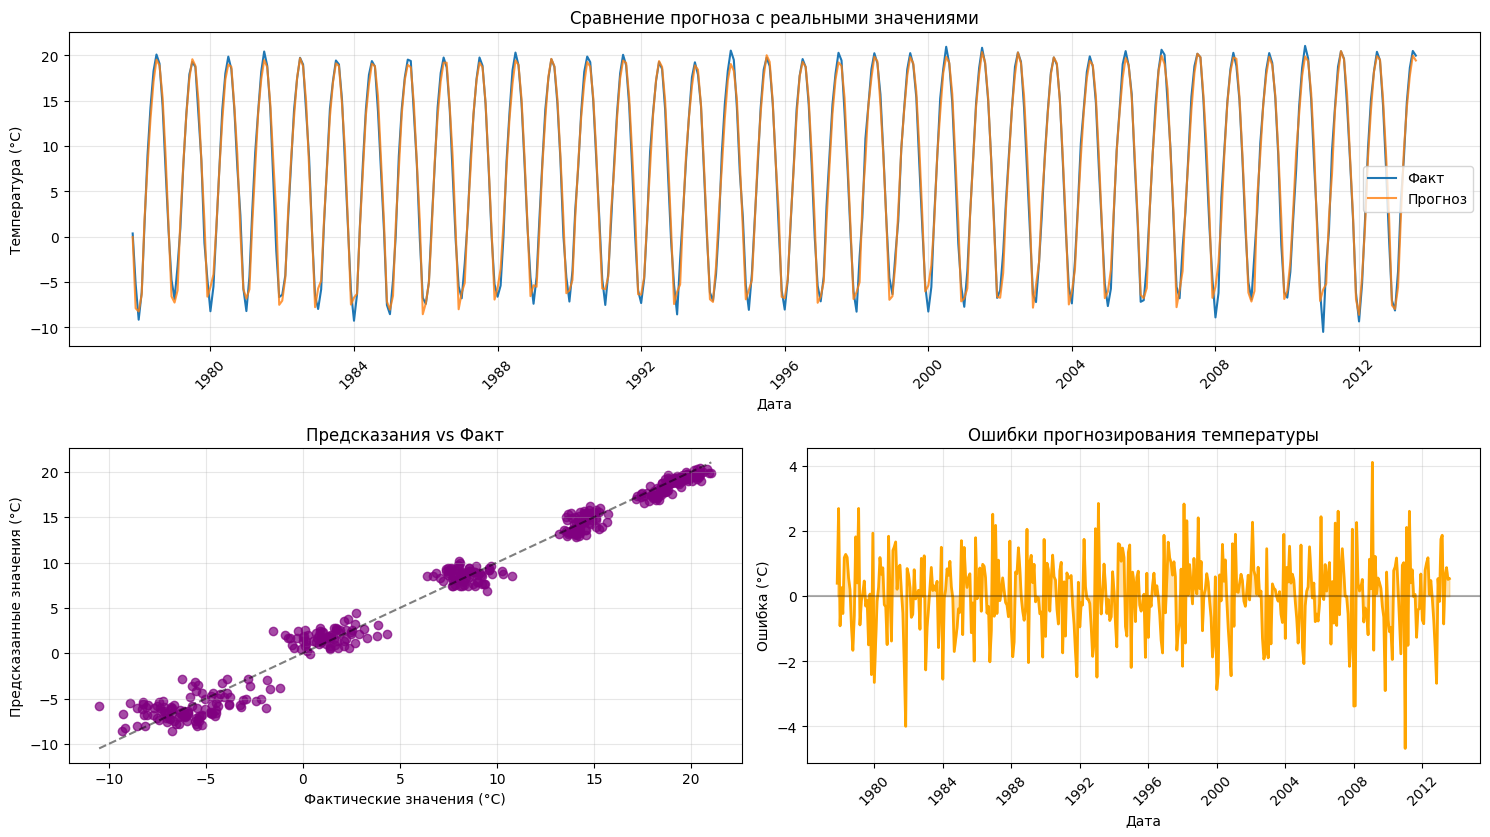

In [141]:
# Подготовка тестовых данных с теми же признаками, что и при обучении
X_test = test_data[["lag_1", "lag_12", "month", "winter_season"]]
y_test = test_data["AverageTemperature"]

# Прогнозирование на тестовой выборке
preds = lr.predict(X_test)

# --- ВИЗУАЛИЗАЦИЯ ---
plt.figure(figsize=(15, 12))

# График 1: Визуализация сравнения прогноза с реальными значениями (занимает всю верхнюю часть)
plt.subplot(3, 1, 1)
plt.plot(test_data.dt, y_test, label="Факт")
plt.plot(test_data.dt, preds, label="Прогноз", alpha=0.80)
plt.title('Сравнение прогноза с реальными значениями')
plt.xlabel('Дата')
plt.ylabel('Температура (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# График 2: Рассеяние предсказаний vs факта
plt.subplot(3, 2, 3)
plt.scatter(y_test, preds, alpha=0.7, color='purple')
# Идеальная линия
min_val = min(y_test.min(), preds.min())
max_val = max(y_test.max(), preds.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
plt.xlabel('Фактические значения (°C)')
plt.ylabel('Предсказанные значения (°C)')
plt.title('Предсказания vs Факт')
plt.grid(True, alpha=0.3)

# График 3: Ошибки прогнозирования
plt.subplot(3, 2, 4)
errors = y_test - preds
plt.plot(test_data.dt, errors, color='orange', linewidth=2)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.fill_between(test_data.dt, errors, alpha=0.3, color='orange')
plt.title('Ошибки прогнозирования температуры')
plt.xlabel('Дата')
plt.ylabel('Ошибка (°C)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [142]:
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mape = np.mean(np.abs((y_test - preds) / y_test)) * 100


print("Результаты оценки прогноза:")
print(f"MAE (Средняя абсолютная ошибка): {mae:.3f}")
print(f"RMSE (Среднеквадратичная ошибка): {rmse:.3f}")
print(f"MAPE (Средняя абсолютная процентная ошибка): {mape:.2f}%")


Результаты оценки прогноза:
MAE (Средняя абсолютная ошибка): 0.924
RMSE (Среднеквадратичная ошибка): 1.196
MAPE (Средняя абсолютная процентная ошибка): 98.10%


Модель прогнозирования температуры показывает хорошие результаты: средняя абсолютная ошибка (MAE) составляет 0.92°C, а среднеквадратичная ошибка (RMSE) - 1.20°C, что означает точность прогноза в пределах примерно одного градуса. Высокий показатель MAPE (98.1%) скорее всего связан с особенностями расчёта этой метрики для температур близких к нулю, где даже небольшие абсолютные ошибки дают большие процентные отклонения